In [23]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pyproj
from shapely.geometry import Polygon
import requests
import io
from zipfile import ZipFile, BadZipFile
from scipy.stats import gamma, norm
import os

## Analiza lokalizacji stacji pomiarowych
    

In [24]:
##------------------------------Zuzia---------------------------------
# Funkcja do konwersji współrzędnych na obiekty Shapely Point
def convert_to_point(row):
    lat, lon = row['Szerokość geograficzna'], row['Długość geograficzna']
    lat_deg, lat_min, lat_sec = map(float, lat.split())
    lon_deg, lon_min, lon_sec = map(float, lon.split())
    latitude = lat_deg + lat_min / 60 + lat_sec / 3600
    longitude = lon_deg + lon_min / 60 + lon_sec / 3600
    return Point(longitude, latitude)

# Czytanie wszystkich stacji pomiarowych
def all_stations():
    data = pd.read_csv('Data/kody_stacji.csv', encoding='windows-1250',delimiter=";")    
    #Zwykłe kodowanie utf-8 nie działało --> po otwarciu pliku w Excelu można sprawdzić rodzaj kodowania 
    data = data.set_index('LP.')   #ustawiam indeks 
    data['geometry'] = data.apply(convert_to_point, axis=1)

    # Tworzenie ramki GeoPandas
    data_gfd = gpd.GeoDataFrame(data, geometry='geometry')
    return data_gfd

#Granice Małopolski
def malopolska_borders():
    # Wczytaj granice Małopolski jako obiekt typu Polygon
    granice_malopolski = gpd.read_file('Data/malopolska.shp')
    polygon_epsg2180 = granice_malopolski.geometry.iloc[0]
    
    # Utwórz transformator do przekształcania współrzędnych
    transformer = pyproj.Transformer.from_crs("EPSG:2180", "EPSG:4326", always_xy=True)
    
    # Przekształć współrzędne poligonu na współrzędne geograficzne
    polygon_wgs84_coords = []
    for x, y in polygon_epsg2180.exterior.coords:
        lon, lat = transformer.transform(x, y)
        polygon_wgs84_coords.append((lon, lat))
    
    # Utwórz obiekt poligonu w formacie EPSG:4326 (współrzędne geograficzne)
    polygon_wgs84 = Polygon(polygon_wgs84_coords)
    # Utworzenie GeoDataFrame z pojedynczym wierszem zawierającym ten poligon
    granice_malopolski = gpd.GeoDataFrame({'geometry': [polygon_wgs84]})
    return granice_malopolski
    
#Szukanie stacji pomiarowych tylko w Małopolsce
def stations_in_malopolska():
    data_gfd = all_stations()
    # Znajdź punkty wewnątrz granic Małopolski
    granice_maloposki = malopolska_borders()
    punkty_wewnatrz_malopolski = gpd.sjoin(data_gfd, granice_maloposki, how="inner", predicate="within")
    punkty_wewnatrz_malopolski = punkty_wewnatrz_malopolski.rename(columns={'ID': 'Kod stacji'})
    return punkty_wewnatrz_malopolski



## Pobieranie danych pomiarowych z 30 lat - od 1991 do 2024

In [25]:
#---------------------------------------------Krzysiek -------------------------------------------------------------------
#Pobieranie danych pomiarowych z 30 lat
def download_weather_data():
    columns = ["Kod stacji", "Nazwa stacji", "Rok", "Miesiąc", "Dzień", "Suma dobowa opadów [mm]", "Status pomiaru SMDB",
               "Rodzaj opadu [S/W/ ]", "Wysokość pokrywy śnieżnej [cm]", "Status pomiaru PKSN", "Wysokość świeżospałego śniegu [cm]",
               "Status pomiaru HSS", "Gatunek śniegu  [kod]", "Status pomiaru GATS",  "Rodzaj pokrywy śnieżnej [kod]", "Status pomiaru RPSN" ]
    dane = pd.DataFrame(columns = columns)
    lata = ["1991_1995/", "1996_2000/", "2001/", "2002/", "2003/", "2004/", "2005/", "2006/", "2007/", "2008/", 
            "2009/", "2010/", "2011/", "2012/", "2013/", "2014/", "2015/", "2016/", "2017/", "2018/", "2019/",
            "2020/", "2021/", "2022/", "2023/", "2024/"]
    
    base_url = "https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/opad/"
    
    # Iteracja przez lata
    for rok in lata:
        if "_" in rok:
            rok_start, rok_end = map(int, rok.rstrip("/").split("_"))
            url = base_url + rok + f"{rok_start}_o.zip"
            response = requests.get(url)
            #print(f"{url}")
            print(f"Response_code = {response.status_code}, Pobieranie danych dla roku = {rok}")
            # Sprawdzenie, czy żądanie się powiodło
            if response.status_code == 200:
                # Wczytanie danych z pliku ZIP do ramki danych
                try:
                    with ZipFile(io.BytesIO(response.content)) as z:
                        for file_name in z.namelist():
                            with z.open(file_name) as f:
                                # Ustawienie odpowiedniego kodowania
                                df = pd.read_csv(f, delimiter=",", header=None, names=columns, encoding="latin-1")
                                dane = pd.concat([dane, df], ignore_index=True)
                except BadZipFile:
                        print(f"Bad ZIP file for {rok}")
        else:
            print(f"Response_code = {response.status_code}, Pobieranie danych dla roku ={rok}")
            for miesiac in range(1, 13):
                # Pobieranie pliku ZIP
                url = base_url + rok + f"{rok[:-1]}_{miesiac:02d}_o.zip"
                response = requests.get(url)
                #print(f"Tu jestem 2 - response_code = {response.status_code}, rok = {rok}, miesiac = {miesiac}")
                # Sprawdzenie, czy żądanie się powiodło
                if response.status_code == 200:
                    # Wczytanie danych z pliku ZIP do ramki danych
                    try:
                        with ZipFile(io.BytesIO(response.content)) as z:
                            for file_name in z.namelist():
                                with z.open(file_name) as f:
                                    # Ustawienie odpowiedniego kodowania
                                    df = pd.read_csv(f, delimiter=",", header=None, names=columns, encoding="latin-1")
                                    dane = pd.concat([dane, df], ignore_index=True)
                    except BadZipFile:
                        print(f"Bad ZIP file for {rok}")
    return dane
#--------------------------------------------------------------------------------------------------------------------------



## Mapowanie stacji z odpowiadającymi im danymi

In [26]:

#-------------------------------------------------------------- Michał -----------------------------------

def rain_malopolska(dane_opady, punkty_wewnatrz_malopolski):
    opady_malopolska = pd.merge(dane_opady, punkty_wewnatrz_malopolski, left_on='Kod stacji', right_on='Kod stacji', how='inner')
    opady_malopolska = opady_malopolska.drop(columns=['Nazwa stacji'])
    opady_malopolska['Data'] = pd.to_datetime(opady_malopolska['Rok'].astype(str) + '-' + opady_malopolska['Miesiąc'].astype(str) + '-' + opady_malopolska['Dzień'].astype(str), format='%Y-%m-%d')
    opady_malopolska = opady_malopolska.drop(columns=['Rok', 'Miesiąc', 'Dzień'])
    
    opady_malopolska = opady_malopolska[['Kod stacji', 'Nazwa', 'Suma dobowa opadów [mm]', 'Data', 'Szerokość geograficzna', 'Długość geograficzna', 'geometry', 'Rzeka'] + [col for col in opady_malopolska.columns if col not in ['Kod stacji', 'Nazwa', 'Suma dobowa opadów [mm]', 'Data', 'Szerokość geograficzna', 'Długość geograficzna', 'geometry', 'Rzeka']]]
    return opady_malopolska
#--------------------------------------------------------------------------


### Stacje dla których zakres dat wnosi 30+ lat i wyświetlanie tego zakresu

In [27]:

def stations_with_range(opady_malopolska):
    result = pd.DataFrame(columns=['Kod stacji', 'Nazwa', 'geometry', 'Zakres dat'])
    for station_code in opady_malopolska['Kod stacji'].unique():
        # Wybierz dane dla danego kodu stacji
        data_for_ID = opady_malopolska[opady_malopolska['Kod stacji'] == station_code]
        
        # Określ maksymalną i minimalną datę
        min_year = data_for_ID['Data'].dt.year.min()
        max_year = data_for_ID['Data'].dt.year.max()
        
        # Obliczanie długości trwania zakresu dat
        dl = max_year - min_year
        
        station_name = data_for_ID['Nazwa'].iloc[0]  # Pobierz nazwę stacji
        geometry = data_for_ID['geometry'].iloc[0]  # Pobierz geometrię stacji
        
        # Dodaj wiersz do wynikowej ramki danych
        result = pd.concat([result, pd.DataFrame({'Kod stacji': [station_code], 'Nazwa': [station_name],
                                                   'geometry': [geometry], 'Zakres dat': [f"{min_year} - {max_year}"],'Długość':dl})],ignore_index=True)

        
        # Filtracja stacji, które mają zakres lat minimum 30letni
        stacje_30lat = result[result['Długość'] >= 30]
        stacje_30lat = stacje_30lat.reset_index(drop=True)
        
    
    return stacje_30lat


### Zostawienie stacji spełniających warunek 30lat

In [28]:
## Zmergowanie danych opadowych z małopolski ze stacjami które mają zakres 30 lat danych, tak aby zostawić te stacje i pomiary dla nich
def merge_rain_malopolska_range(opady_malopolska,stacje_30lat):
    lokalizowane_stacje = opady_malopolska.loc[opady_malopolska['Nazwa'].isin(stacje_30lat['Nazwa'])]

    return lokalizowane_stacje  

## Wizualizacje

In [29]:
#------------------------------------------------ Wizualizacje --------------------------------------------
#Wizualizacja wszystkich stacji pomiarowych na mapie
def plot_all_stations(data_gfd):

    # Wczytanie granic administracyjnych Polski
    poland = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    poland = poland[poland.name == 'Poland']
    
    # Tworzenie mapy
    fig, ax = plt.subplots(figsize=(7, 5))
    poland.plot(ax=ax, color='lightgreen', edgecolor='black')
    data_gfd.plot(ax=ax, marker='o', color='red', markersize=1)
    plt.title('Mapa Polski ze wszystkimi stacjami')
    plt.xlabel('Długość geograficzna')
    plt.ylabel('Szerokość geograficzna')
    plt.show()
    plt.savefig("Polska_stations.png")
    
#Wizualizacja stacji pomiarowych w Małopolsce - krzyżykiem zaznaczono stacje z których otrzymano pomiary opadów
def plot_malopolska_stations(malopolska_stations,opady_malopolska):
    opady_plot = opady_malopolska[['Kod stacji','Nazwa','geometry']].drop_duplicates()
    # Tworzenie ramki GeoPandas z podanymi danymi
    opady_plot = gpd.GeoDataFrame(opady_plot, geometry='geometry')
    granice_maloposki = malopolska_borders()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    # poland.plot(ax=ax, color='lightgreen', edgecolor='black')
    granice_maloposki.plot(ax=ax,color="lightblue")
    opady_plot.plot(ax=ax, marker='x', color='blue',alpha=0.7,label='Stacje, dla których wykonano pomiary opadów z ponad 30 lat')
    malopolska_stations.plot(ax=ax, marker='o', color='red',alpha=0.5,markersize=1,label='Wszystkie stacje pomiarowe')
                
    plt.legend()
    
    plt.title('Mapa Małopolski ze stacjami')
    plt.xlabel('Długość geograficzna')
    plt.ylabel('Szerokość geograficzna')
    plt.savefig(os.path.join("Results", "Małopolska_stations.png"))
    plt.show() 

    
# -------------------------------------------------------------------------------------------------------------

# ------------------------------------------------- SPI ---------------------------------------------------------
def plot_spi(spi_all_stations):
    kody_stacji = spi_all_stations['Kod stacji'].unique()
    for kod in kody_stacji:
        stacja = spi_all_stations[spi_all_stations['Kod stacji'] == kod].copy()
        stacja = stacja.reset_index(drop=True)
        nazwa = stacja['Nazwa'][0]
        fig, ax = plt.subplots(1, 3, figsize=(13, 4))
        ax[0].plot(stacja['Date'], stacja['SPI-1'], marker='o', linestyle='-')
        ax[0].set_title(f'Zmienność SPI-1 w czasie dla {kod}')  # Fix: set_title instead of title
        ax[0].set_xlabel('Data')  # Fix: set_xlabel instead of xlabel
        ax[0].set_ylabel('SPI')  # Fix: set_ylabel instead of ylabel
        ax[0].grid(True)
        ax[0].tick_params(axis='x', rotation=45)  # Fix: tick_params to set rotation of x-axis labels
        ax[1].plot(stacja['Date'], stacja['SPI-3'], marker='o', linestyle='-')
        ax[1].set_title(f'Zmienność SPI-3 w czasie dla {kod}')  # Fix: set_title instead of title
        ax[1].set_xlabel('Data')  # Fix: set_xlabel instead of xlabel
        ax[1].set_ylabel('SPI')  # Fix: set_ylabel instead of ylabel
        ax[1].grid(True)
        ax[1].tick_params(axis='x', rotation=45)  # Fix: tick_params to set rotation of x-axis labels
        ax[2].plot(stacja['Date'], stacja['SPI-12'], marker='o', linestyle='-')
        ax[2].set_title(f'Zmienność SPI-12 w czasie dla {kod} ')  # Fix: set_title instead of title
        ax[2].set_xlabel('Data')  # Fix: set_xlabel instead of xlabel
        ax[2].set_ylabel('SPI')  # Fix: set_ylabel instead of ylabel
        ax[2].grid(True)
        ax[2].tick_params(axis='x', rotation=45)  # Fix: tick_params to set rotation of x-axis labels
        plt.suptitle(f'Wykresy zmienności SPI w czasie dla stacji {nazwa}', fontsize=16)  # Title for the entire set of plots

        plt.tight_layout()  # Dostosowanie układu, aby uniknąć obcięcia etykiet osi X
        plt.savefig(os.path.join("Results/SPI_plots", f'{nazwa} - zmienność wartości SPI.png'))

        plt.show()


## Wypełnianie brakujących danych opadowych

In [30]:

def fill_missing_values(opady_malopolska_spi):
    # Zainicjuj pustą listę do przechowywania danych
    data_frames = []
    
    # Pętla dla każdego unikalnego ID w kolumnie Kod stacji
    for station_code in opady_malopolska_spi['Kod stacji'].unique():
        # Wybierz dane dla danego kodu stacji
        data_for_ID = opady_malopolska_spi[opady_malopolska_spi['Kod stacji'] == station_code]
        
        # Określ maksymalną i minimalną datę
        min_date = data_for_ID['Data'].min()
        max_date = data_for_ID['Data'].max()
        
        # Dodaj wszystkie brakujące daty dzienne
        full_dates = pd.date_range(start=min_date, end=max_date, freq='D')
        missing_dates = full_dates[~full_dates.isin(data_for_ID['Data'])]
        
        # Utwórz ramkę danych z brakującymi datami
        missing_data = pd.DataFrame({'Data': missing_dates, 'Kod stacji': station_code, 'Suma dobowa opadów [mm]': np.nan})
        
        # Dołącz brakujące dane do oryginalnych danych
        data_for_ID = pd.concat([data_for_ID, missing_data])
        
        # Dodaj dodatkową datę na początku i na końcu
        data_for_ID = pd.concat([data_for_ID, pd.DataFrame({'Data': [min_date, max_date], 
                                                            'Kod stacji': [station_code, station_code], 
                                                            'Suma dobowa opadów [mm]': [np.nan, np.nan]})], ignore_index=True)
        # ????????????????????????????????????????????/
        # # Dodaj dodatkową datę na początku i na końcu
        # data_for_ID = pd.concat([data_for_ID, pd.DataFrame({'Data': [min_date - pd.Timedelta(days=1), max_date + pd.Timedelta(days=1)], 
        #                                                 'Kod stacji': [station_code, station_code], 
        #                                                 'Suma dobowa opadów [mm]': [np.nan, np.nan]})], ignore_index=True)
    
        
        # Posortuj dane po dacie
        data_for_ID = data_for_ID.sort_values(by='Data').reset_index(drop=True)
        
        # Wypełnij brakujące wartości
        np.random.seed(69)  # Ustaw ziarno losowości dla powtarzalności
        filled_values = 3 * data_for_ID.groupby([data_for_ID['Data'].dt.year, data_for_ID['Data'].dt.day])['Suma dobowa opadów [mm]'].transform('median')
        filled_values = filled_values.sample(n=len(data_for_ID), replace=True).reset_index(drop=True)
        data_for_ID['Suma dobowa opadów [mm]'].fillna(filled_values, inplace=True)
        
        # Dodaj DataFrame do listy
        data_frames.append(data_for_ID)
    
    # Połącz wszystkie ramki danych w jeden DataFrame
    opady_malopolska_iniekcja = pd.concat(data_frames)
    opady_malopolska_iniekcja = opady_malopolska_iniekcja.reset_index(drop=True)
    opady_malopolska_iniekcja['Data'] = pd.to_datetime(opady_malopolska_iniekcja['Data'])  
    opady_malopolska_iniekcja['Rok'] = opady_malopolska_iniekcja['Data'].dt.year
    opady_malopolska_iniekcja['Miesiąc'] = opady_malopolska_iniekcja['Data'].dt.month
    return opady_malopolska_iniekcja

## Liczenie SPI

In [31]:
def calculate_spi(data):
    alpha, loc, beta = gamma.fit(data.dropna(), floc=0)
    cdf = gamma.cdf(data, alpha, loc=loc, scale=beta)
    spi = norm.ppf(cdf)
    return spi
    
def function_spi_df(opady_malopolska_iniekcja):
    kody_stacji = opady_malopolska_iniekcja['Kod stacji'].unique()
    all_results = pd.DataFrame()
    for kod in kody_stacji:
        stacja = opady_malopolska_iniekcja[opady_malopolska_iniekcja['Kod stacji'] == kod].copy()
        stacja.loc[:, 'Suma_mies'] = stacja.groupby(['Rok', 'Miesiąc'])['Suma dobowa opadów [mm]'].transform('sum')
        stacja = stacja.reset_index(drop=True)
        
        suma_mies = stacja.groupby(['Kod stacji','Rok','Miesiąc'])['Suma_mies'].mean().reset_index()
        suma_mies['Suma_3_mies'] = suma_mies['Suma_mies'].rolling(window=3).sum()
        suma_mies['Suma_12_mies'] = suma_mies['Suma_mies'].rolling(window=12).sum()
        suma_mies
        
        #SPI - 1
        stacja_spi1 = suma_mies[suma_mies['Suma_mies'] > 0].reset_index(drop=True)
        stacja_spi1.loc[:, 'SPI-1'] = calculate_spi(stacja_spi1['Suma_mies'])
        stacja_spi1.loc[:, 'SPI-3'] = calculate_spi(stacja_spi1['Suma_3_mies'])
        stacja_spi1.loc[:, 'SPI-12'] = calculate_spi(stacja_spi1['Suma_12_mies'])
        
        stacja_spi1['Date'] = pd.to_datetime(stacja_spi1[['Rok', 'Miesiąc']].rename(columns={'Rok': 'year', 'Miesiąc': 'month'}).assign(day=1))
    
        stacja_spi1 = stacja_spi1.reindex(columns=['Kod stacji','Rok', 'Miesiąc', 'SPI-1', 'SPI-3', 'SPI-12','Date'])
    
        all_results = pd.concat([all_results, stacja_spi1], ignore_index=True)
        kody_stacji = all_results['Kod stacji'].unique()
        station_names = {}
        
        for kod in kody_stacji:
            nazwa_stacji = opady_malopolska_iniekcja[opady_malopolska_iniekcja['Kod stacji'] == kod]['Nazwa'].iloc[0]
            station_names[kod] = nazwa_stacji
    
        all_results['Nazwa'] = all_results['Kod stacji'].map(station_names)
    return all_results

def save_spi_excel(df):
    # Assuming df is your DataFrame containing the data
    df = df.drop(columns=['Date'])
    df.to_excel(os.path.join("Results/SPI_results", "SPI_wszystkie_stacje.xlsx"), index=False)
   

## Wywołanie funkcji

In [32]:
# Wszystkie stacje pomiarowe zlokalizowane w Małopolsce
malopolska_stations = stations_in_malopolska()

#--------- Krzysiek - pobranie wszystkich danych z 30 lat ----------------
all_stations_data = download_weather_data()



Response_code = 200, Pobieranie danych dla roku = 1991_1995/


C:\Users\Zuzia\AppData\Local\Temp\ipykernel_20620\502822681.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dane = pd.concat([dane, df], ignore_index=True)


Response_code = 200, Pobieranie danych dla roku = 1996_2000/
Response_code = 200, Pobieranie danych dla roku =2001/
Response_code = 200, Pobieranie danych dla roku =2002/
Response_code = 200, Pobieranie danych dla roku =2003/
Response_code = 200, Pobieranie danych dla roku =2004/
Response_code = 200, Pobieranie danych dla roku =2005/
Response_code = 200, Pobieranie danych dla roku =2006/
Response_code = 200, Pobieranie danych dla roku =2007/
Response_code = 200, Pobieranie danych dla roku =2008/
Response_code = 200, Pobieranie danych dla roku =2009/
Response_code = 200, Pobieranie danych dla roku =2010/
Response_code = 200, Pobieranie danych dla roku =2011/
Response_code = 200, Pobieranie danych dla roku =2012/
Response_code = 200, Pobieranie danych dla roku =2013/
Response_code = 200, Pobieranie danych dla roku =2014/
Response_code = 200, Pobieranie danych dla roku =2015/
Response_code = 200, Pobieranie danych dla roku =2016/
Response_code = 200, Pobieranie danych dla roku =2017/
Resp

C:\Users\Zuzia\AppData\Local\Temp\ipykernel_20620\1047915703.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_for_ID['Suma dobowa opadów [mm]'].fillna(filled_values, inplace=True)
C:\Users\Zuzia\AppData\Local\Temp\ipykernel_20620\1047915703.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

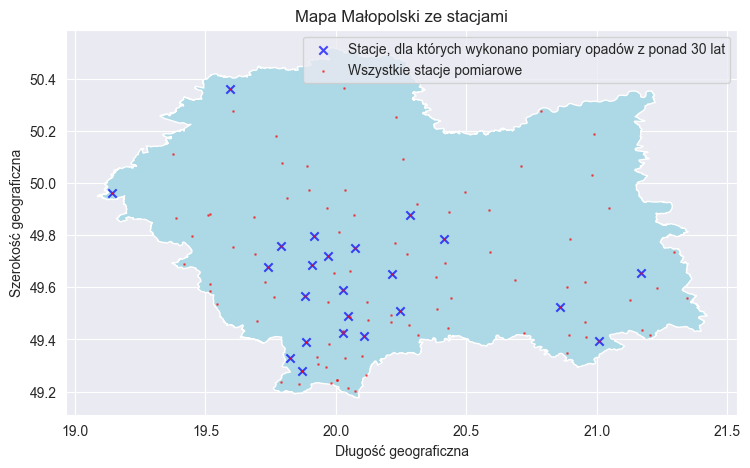

In [33]:
#---------- Michał - stacje pomiarowe w Małopolsce z pomiarami opadów
opady_malopolska = rain_malopolska(all_stations_data, malopolska_stations)
# -------------------
stacje_z_zakresem_30 = stations_with_range(opady_malopolska)
opady_malopolska_spi = merge_rain_malopolska_range(opady_malopolska,stacje_z_zakresem_30)
opady_malopolska_iniekcja = fill_missing_values(opady_malopolska_spi)

plot_malopolska_stations(malopolska_stations,stacje_z_zakresem_30)



In [36]:
spi_all_stations = function_spi_df(opady_malopolska_iniekcja)
save_spi_excel(spi_all_stations)
spi_all_stations

,Kod stacji,Rok,Miesiąc,SPI-1,SPI-3,SPI-12,Date,Nazwa
0,249190010,1991,1,-1.115746,NaN,NaN,1991-01-01,JAWISZOWICE
1,249190010,1991,2,-2.525874,NaN,NaN,1991-02-01,JAWISZOWICE
2,249190010,1991,3,-0.227685,-1.722303,NaN,1991-03-01,JAWISZOWICE
3,249190010,1991,4,-1.147119,-1.737143,NaN,1991-04-01,JAWISZOWICE
4,249190010,1991,5,1.198549,-0.014889,NaN,1991-05-01,JAWISZOWICE
...,...,...,...,...,...,...,...,...
9101,250190260,2023,10,0.364467,0.875458,0.256006,2023-10-01,GOLCZOWICE
9102,250190260,2023,11,0.164012,0.838809,0.491249,2023-11-01,GOLCZOWICE
9103,250190260,2023,12,0.539540,0.426603,0.807248,2023-12-01,GOLCZOWICE
9104,250190260,2024,1,-0.561383,0.021096,0.934534,2024-01-01,GOLCZOWICE


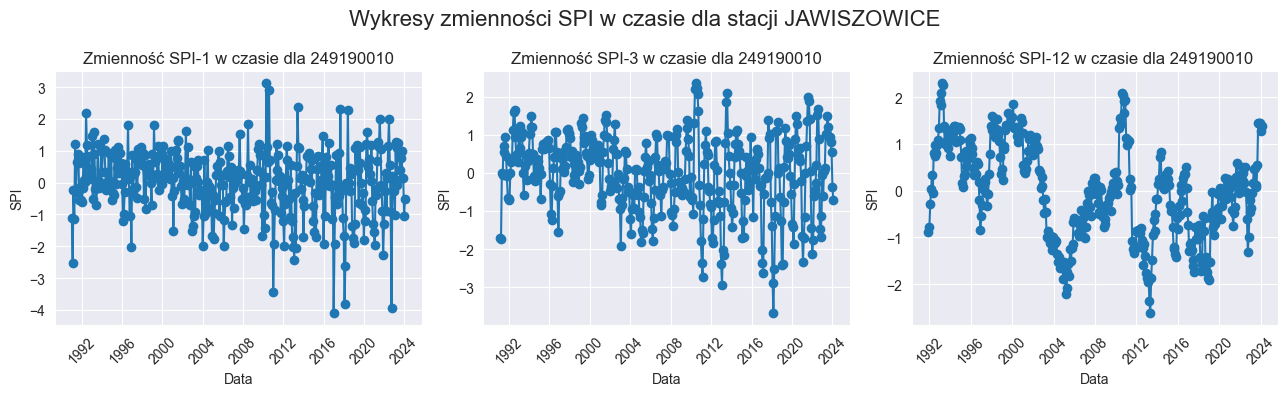

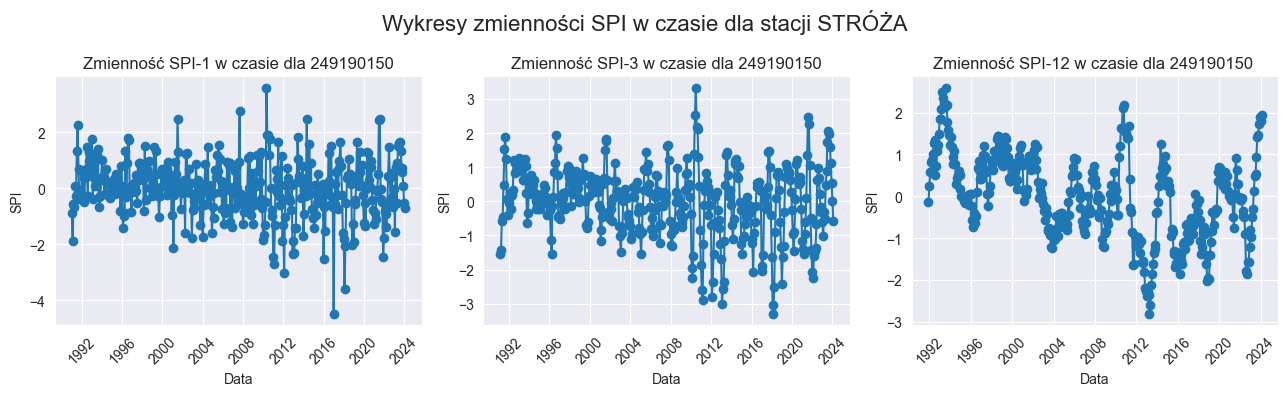

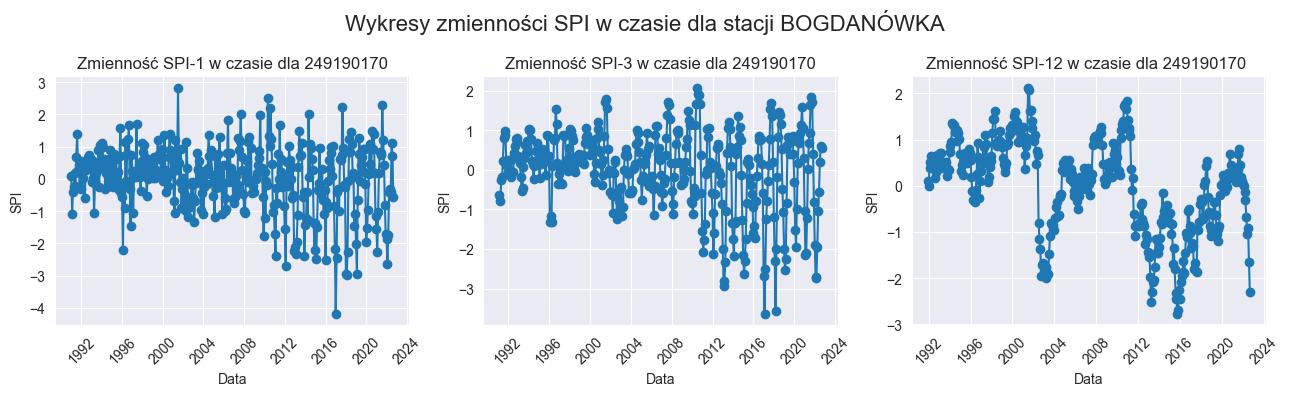

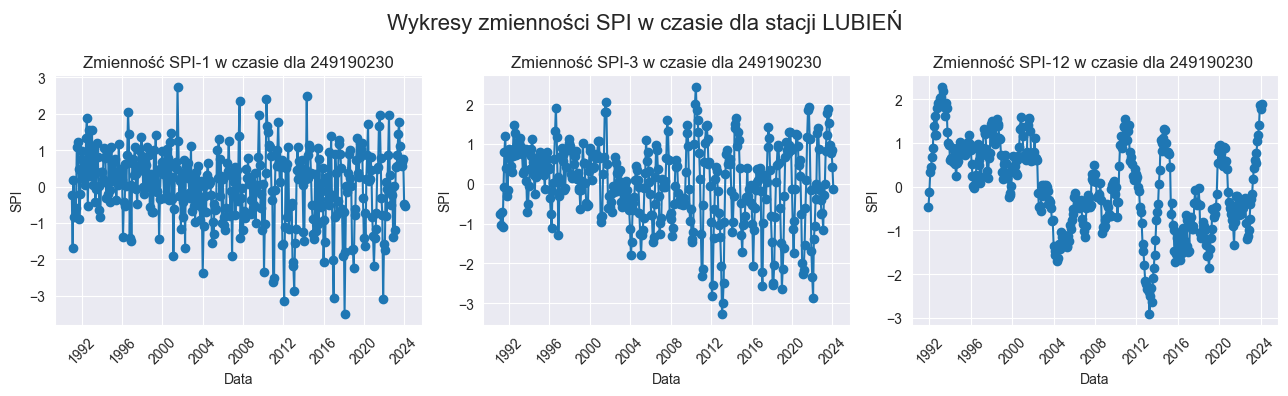

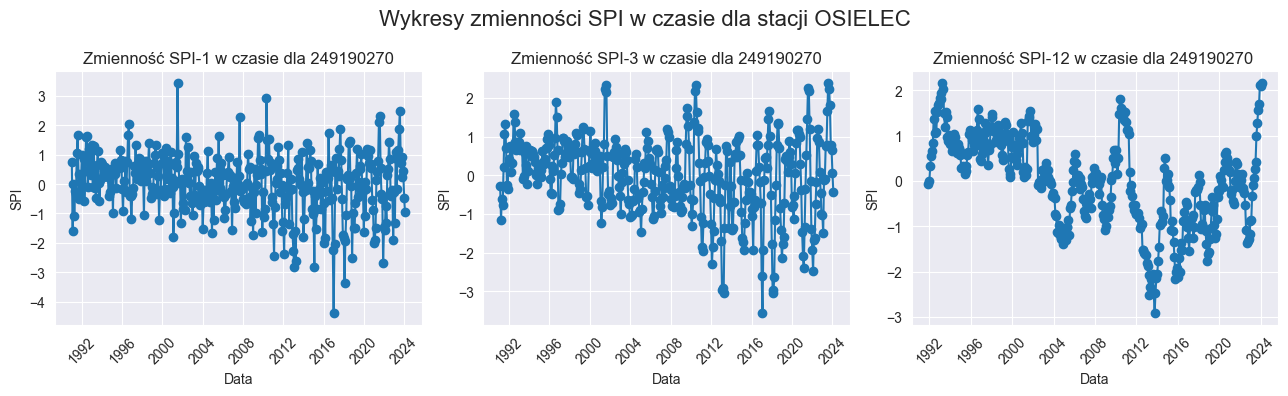

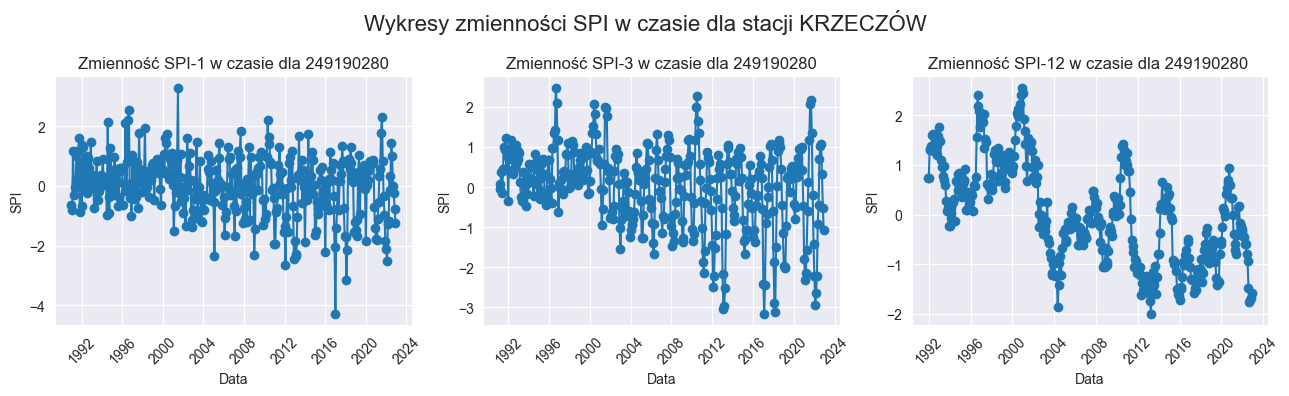

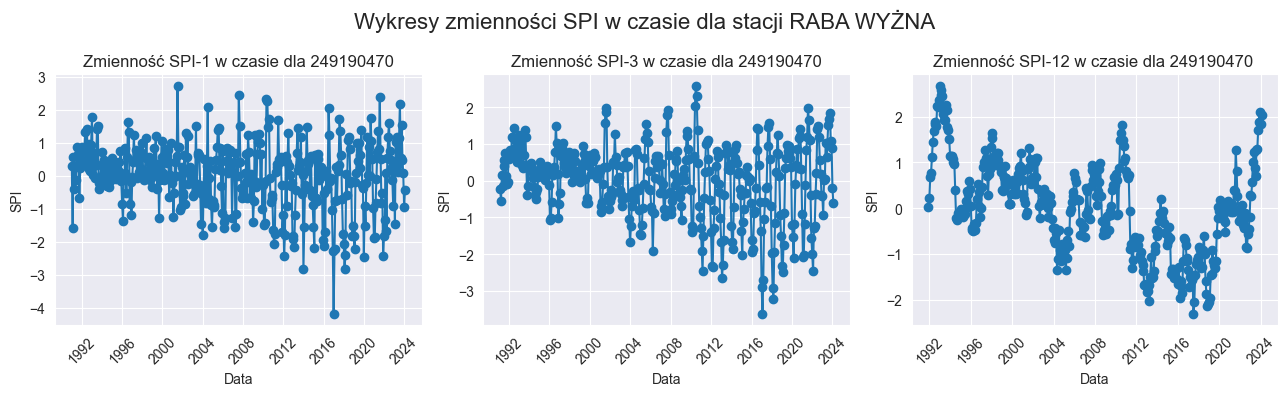

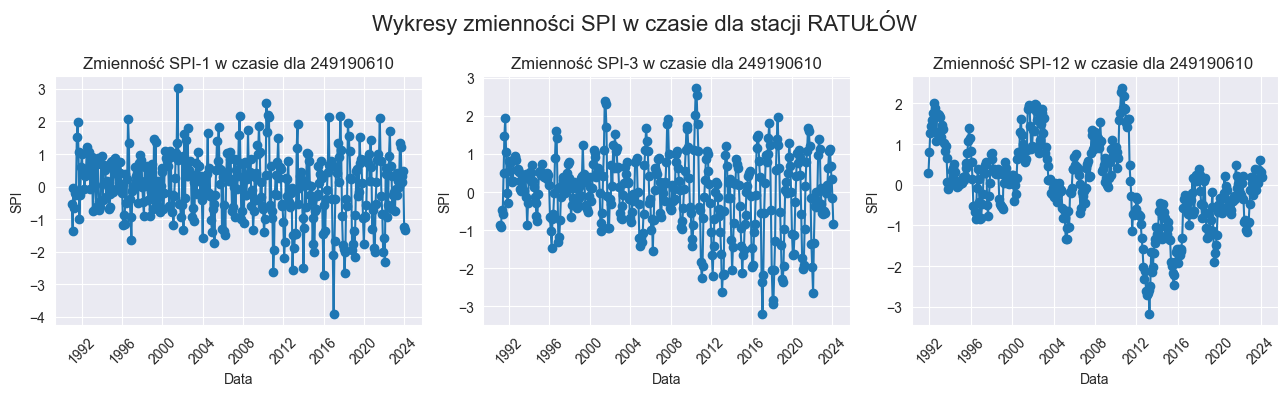

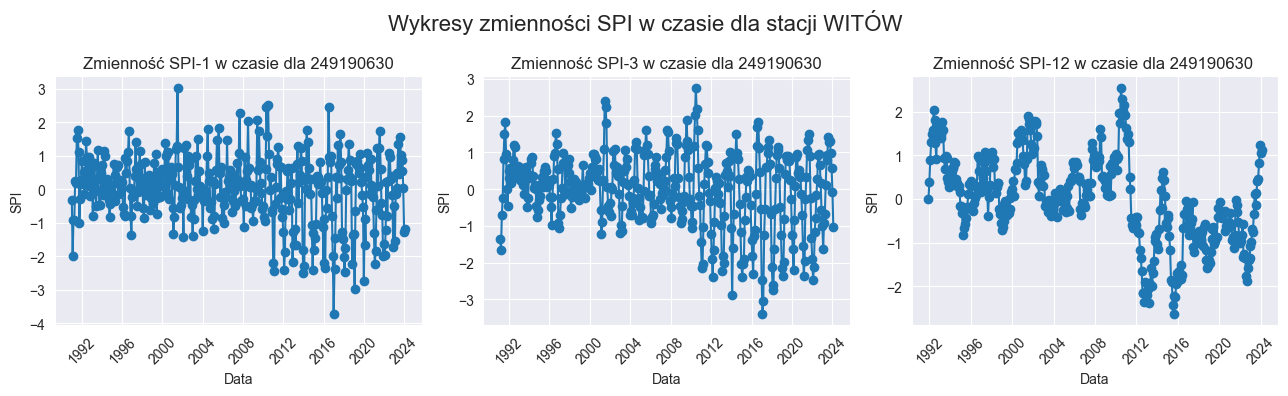

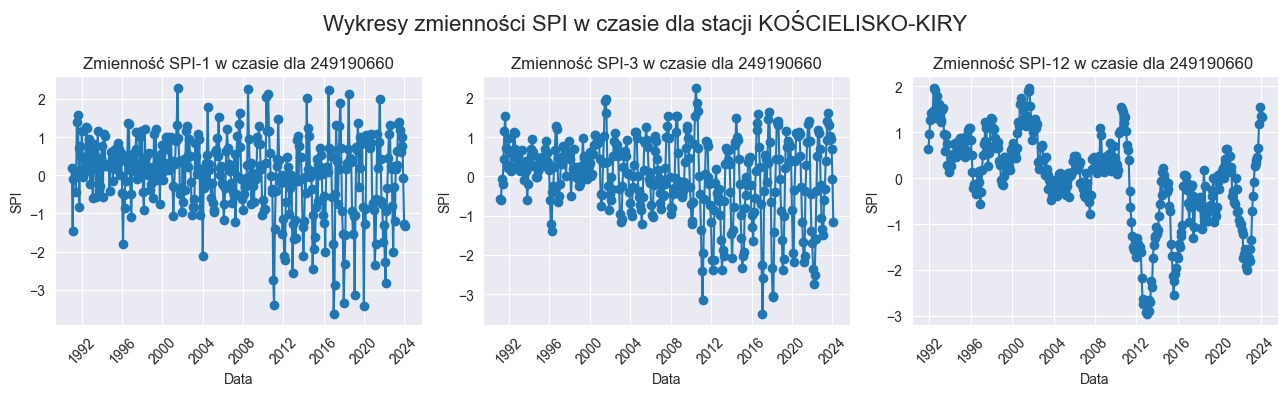

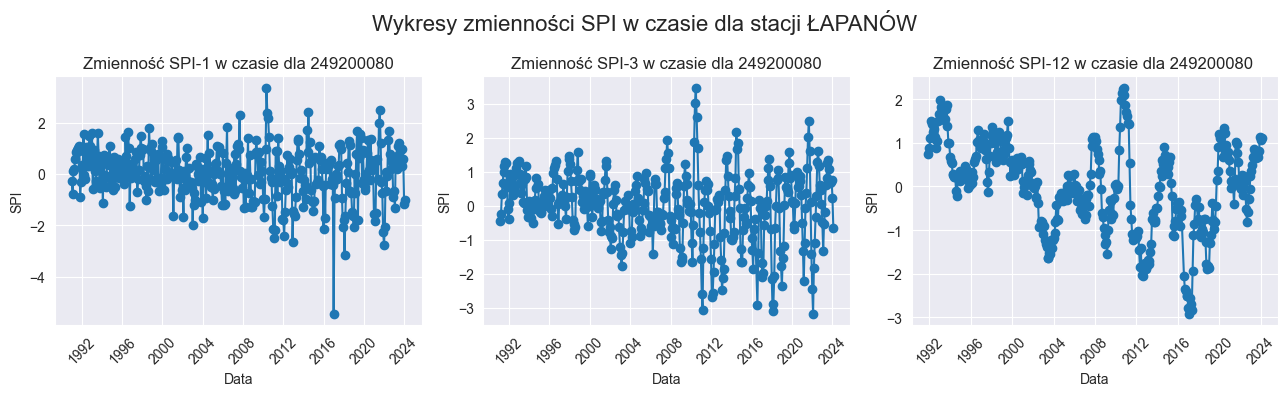

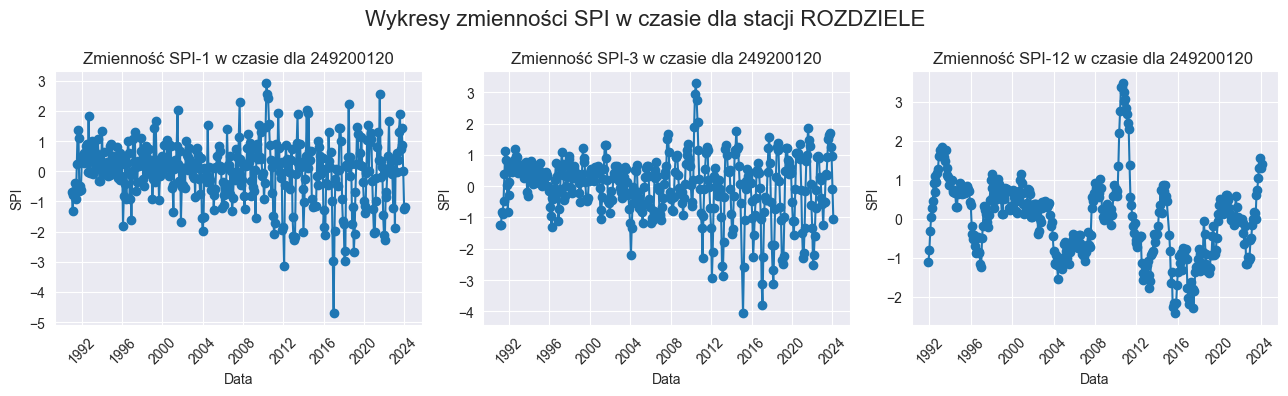

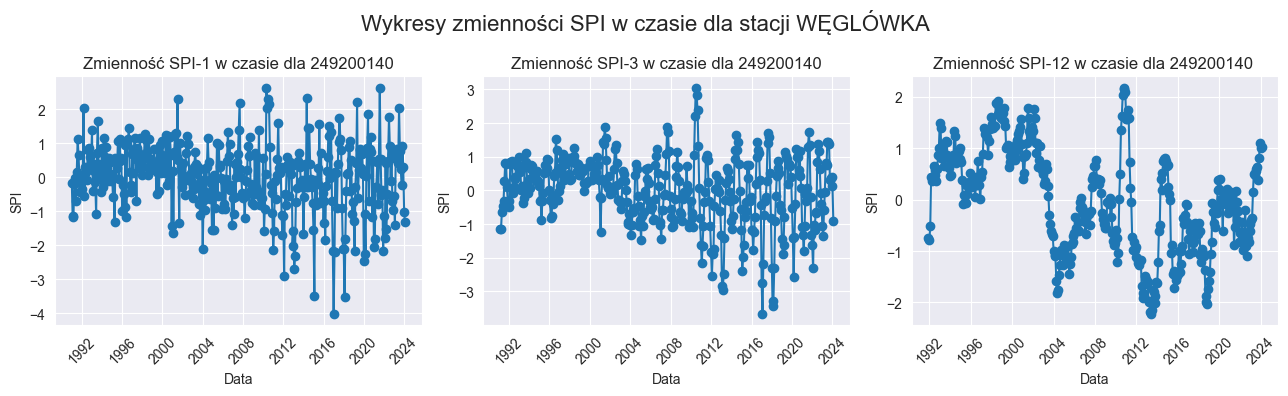

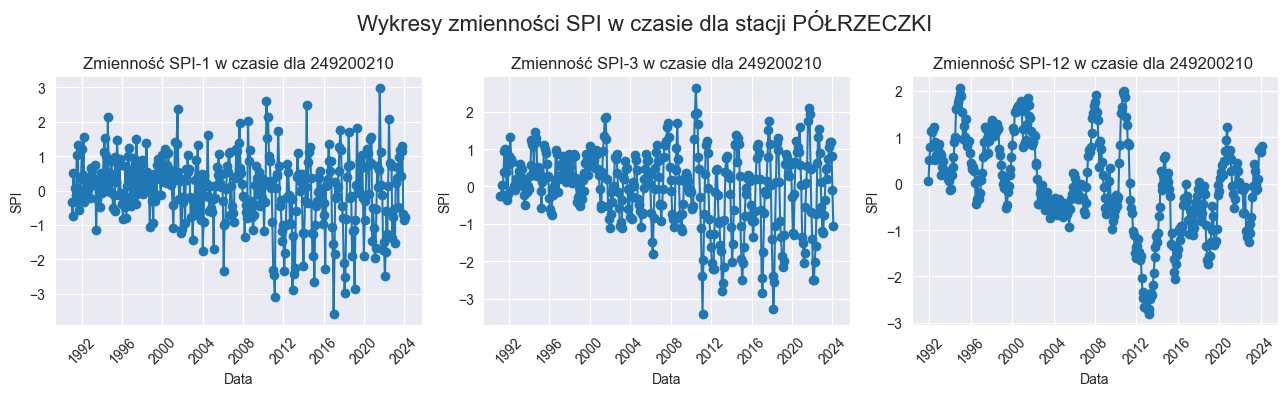

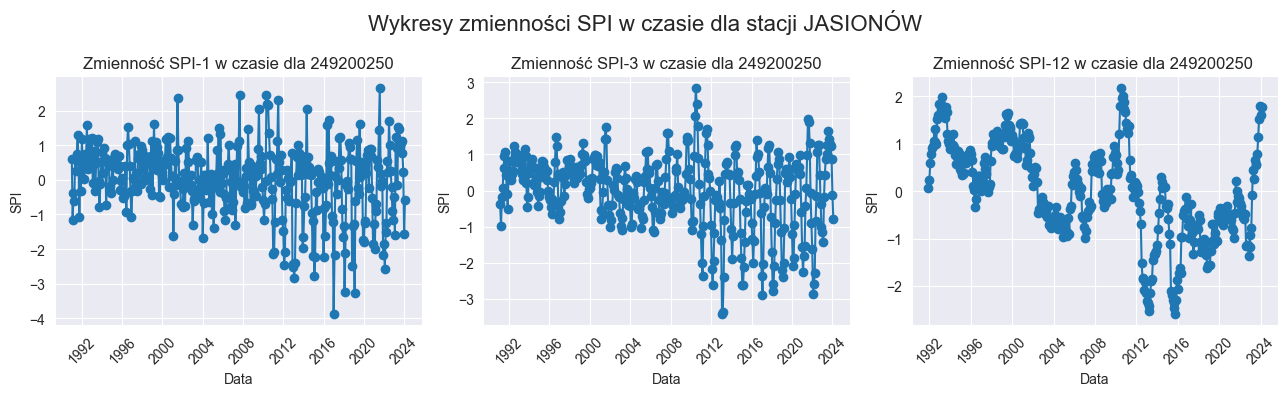

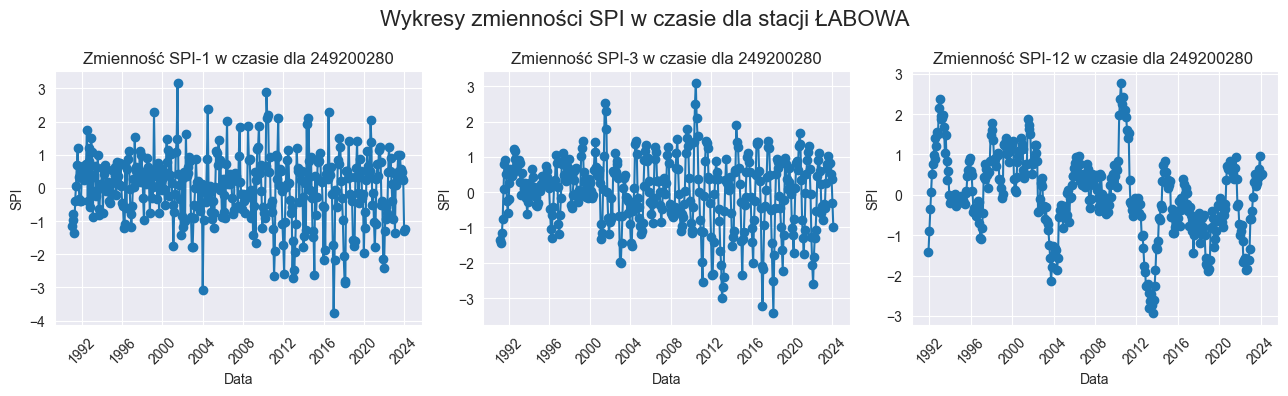

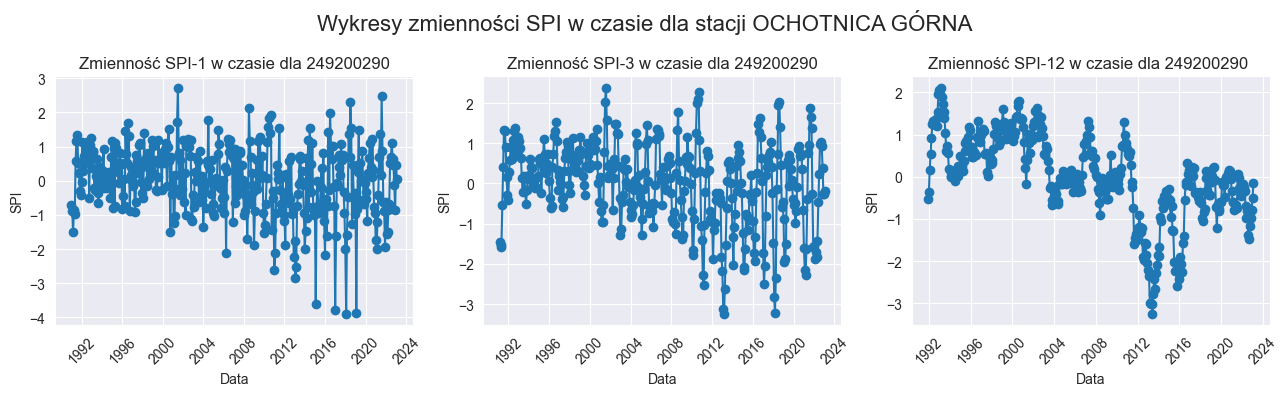

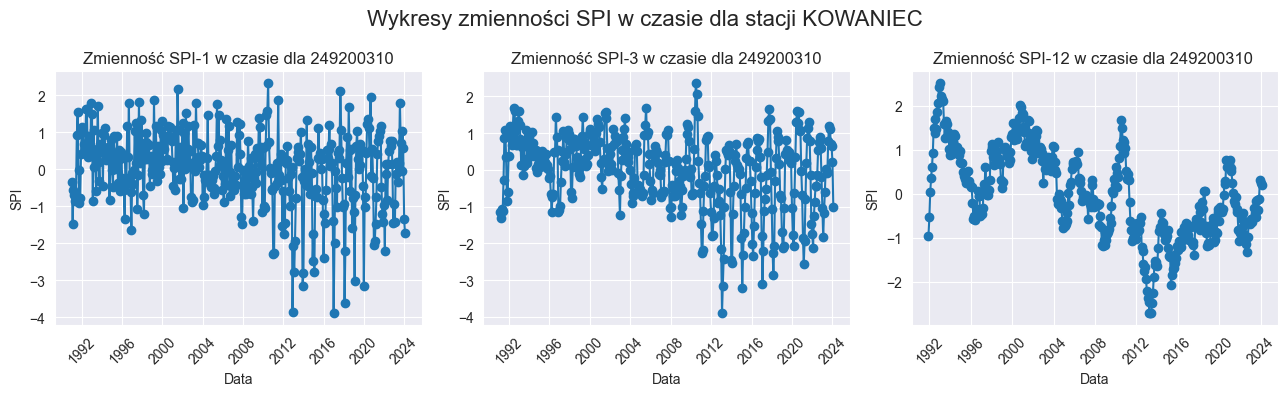

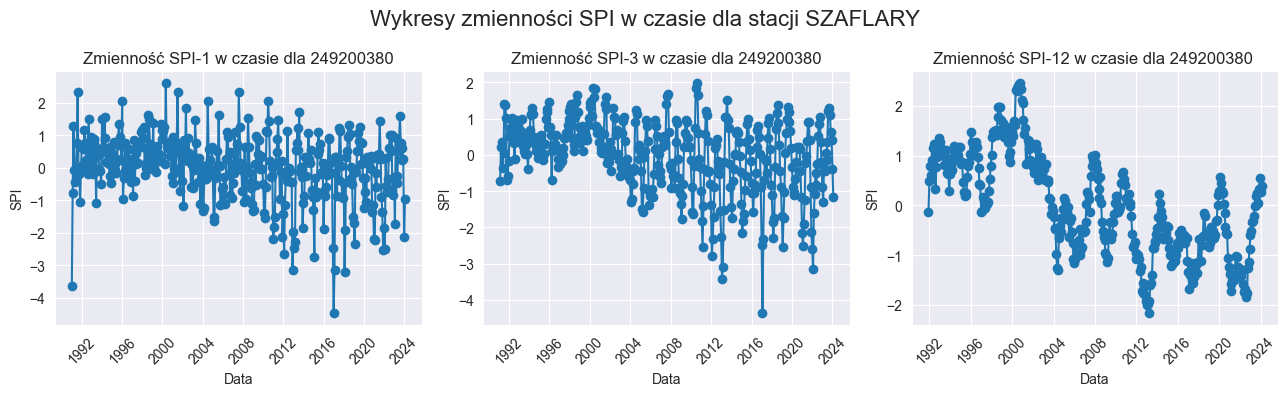

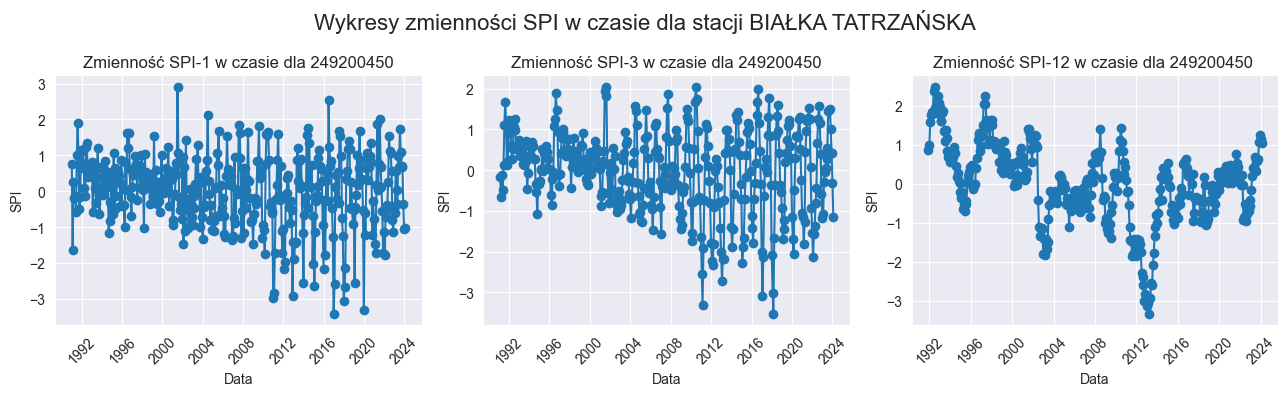

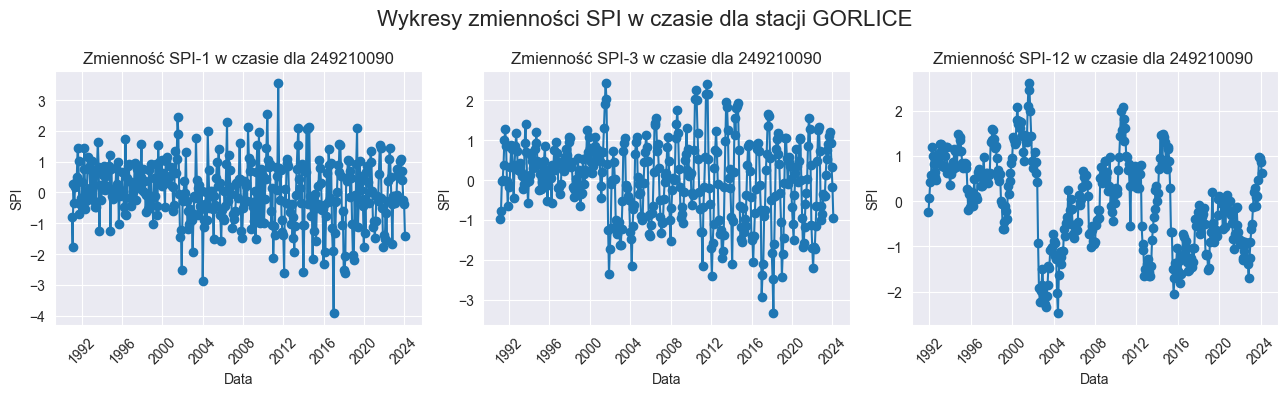

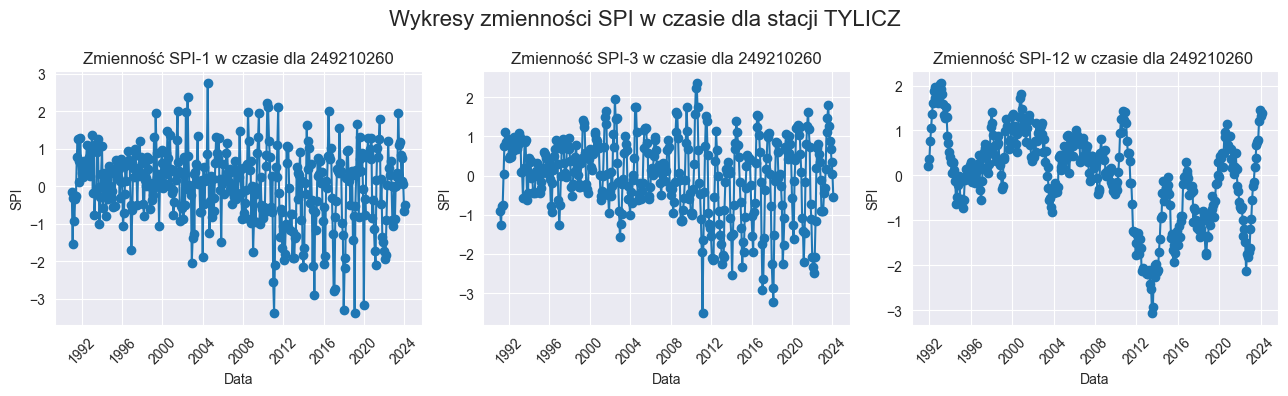

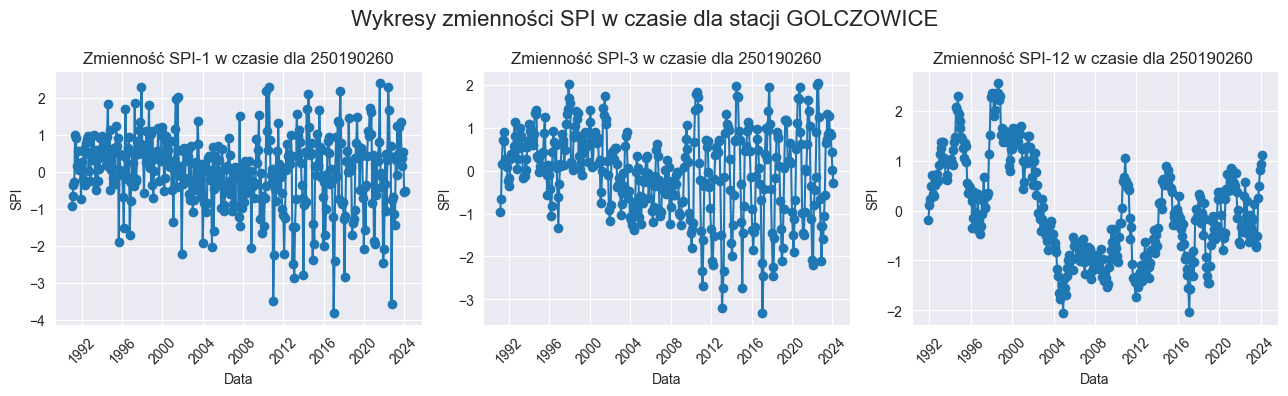

In [37]:
plot_spi(spi_all_stations)

## EDA

In [ ]:
# Usuwanie duplikatów 
opady_malopolska_spi = opady_malopolska_spi.drop_duplicates()

#Liczenie wartości brakujących
nan_counts = opady_malopolska_spi.isna().sum()
nan_counts


### Boxploty

In [ ]:
import plotly.graph_objs as go
import pandas as pd

# Przygotowanie danych
grouped = opady_malopolska_spi.groupby('Kod stacji')['Suma dobowa opadów [mm]']
data = [group_data.dropna().values for group_name, group_data in grouped]

# Tworzenie interaktywnego wykresu pudełkowego
fig = go.Figure()

# Dodawanie pudełek dla każdej stacji
for i, (group_name, group_data) in enumerate(grouped):
    fig.add_trace(go.Box(y=group_data.dropna().values, name=group_name))

# Konfiguracja układu
fig.update_layout(
    title='Wykres pudełkowy opadów dla różnych stacji',
    xaxis=dict(title='Kod stacji'),
    yaxis=dict(title='Suma dobowa opadów [mm]')
)

# Wyświetlenie wykresu
fig.show()

In [ ]:
opady_malopolska_spi.iloc[:, :-1].describe()

### Histogramy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lista unikalnych identyfikatorów stacji
unique_station_ids = opady_malopolska_spi['Kod stacji'].unique()

# Utwórz układ subplotów 10x5
fig, axs = plt.subplots(10, 5, figsize=(20, 40))

# Iteracja po wszystkich stacjach i wyświetlanie histogramów na odpowiednich subplotach
for i, station_id in enumerate(unique_station_ids):
    # Wybierz dane dla danego ID
    data_for_ID = opady_malopolska_spi[opady_malopolska_spi['Kod stacji'] == station_id]
    
    # Oblicz współrzędne subplotu dla danego indeksu
    row = i // 5
    col = i % 5
    
    # Stwórz histogram dla kolumny "Suma dobowa opadów [mm]" dla danego ID
    axs[row, col].hist(data_for_ID['Suma dobowa opadów [mm]'], bins=10, alpha=0.5)
    
    # Dodaj etykiety i tytuł dla danego subplotu
    axs[row, col].set_xlabel('Suma dobowa opadów [mm]')
    axs[row, col].set_ylabel('Liczba obserwacji')
    axs[row, col].set_title(f'Histogram Opadów dla Kodu stacji {station_id}')

# Aby uniknąć wyświetlania pustych subplotów, ukryj niepotrzebne subploty
for i in range(len(unique_station_ids), 10*5):
    row = i // 5
    col = i % 5
    fig.delaxes(axs[row, col])

# Wyświetl subploty
plt.tight_layout()
plt.show()


### Wykresy zmienności sumy opadów w czasie

In [ ]:
# Pobierz unikalne kody stacji
unique_station_codes = opady_malopolska_iniekcja['Kod stacji'].unique()

# Oblicz liczbę unikalnych kodów stacji
num_unique_codes = len(unique_station_codes)

# Oblicz liczbę wierszy i kolumn na podstawie liczby unikalnych kodów stacji
num_rows = min(num_unique_codes // 5 + 1, 5)
num_cols = min(num_unique_codes, 5)

# Utwórz układ subplotów
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Iteruj po wszystkich podwykresach
for i, ax in enumerate(axes.flat):
    # Sprawdź, czy indeks jest mniejszy niż liczba unikalnych kodów stacji
    if i < num_unique_codes:
        # Pobierz kod stacji dla danego indeksu
        station_code = unique_station_codes[i]
        
        # Wybierz dane dla danego kodu stacji
        data_for_ID = opady_malopolska_iniekcja[opady_malopolska_iniekcja['Kod stacji'] == station_code]
        
        # Narysuj wykres liniowy
        ax.plot(data_for_ID['Data'], data_for_ID['Suma dobowa opadów [mm]'])
        # Obróć podpisy na osi x
        ax.tick_params(axis='x', rotation=45)
        # Dodaj etykiety osi
        ax.set_xlabel('Data')
        ax.set_ylabel('Suma dobowa opadów [mm]')
        
        # Dodaj tytuł
        ax.set_title(f'Kod stacji: {station_code}')
    else:
        # Ukryj subplot, jeśli indeks jest większy lub równy liczbie unikalnych kodów stacji
        ax.axis('off')

# Dostosuj układ subplotów
plt.tight_layout()

# Pokaż wykres
plt.show()